# Analysis



Now we'll take the CONLL data and do some analysis. Like 
* plot the frequencies of some lemma
* look at some lemmas contexts
* analyze some lemmas collocations


## 0. Imports and data upload

In [1]:
import pandas as pd

In [2]:
import re

In [3]:
import os

In [4]:
conllfiles = (r"../data/conll")

In [5]:
corpus_annotations = {}
for filename in os.listdir(conllfiles):
    if '.conll' in filename:
        path = os.path.join(conllfiles, filename)  
        data = pd.read_csv(path) 
        corpus_annotations[filename] = data

In [6]:
corpus_annotations['SNP27112366-19180528-0-0-0-0.conll']

,Token,Lemma,PoS,Sentence_idx
0,+,+,KON,0
1,“,--,$(,0
2,267,267,CARD,0
3,Morgen-Ausgabe,Morgen-Ausgabe,NN,0
4,\n\n,\n\n,_SP,0
...,...,...,...,...
45780,\n\n,\n\n,_SP,3202
45781,t,t,NE,3202
45782,3,3,CARD,3202
45783,j,j,NE,3203


In [7]:
corpus_metadata = pd.read_csv('../data/metadata/MVP-Test-Korpus_Metadata-v02.csv')

In [8]:
corpus_metadata = corpus_metadata.set_index('Filename')

## 1. Search lemma and plot frequency

In [23]:
class WordSearchEngine:
    
    def __init__(self, corpus_annotated, corpus_metadata):
        self.prepare_index_dataframe_for_search(corpus_annotated, corpus_metadata)
    
    def prepare_index_dataframe_for_search(self, corpus_annotated, corpus_metadata):
        for filename, annotated_text in corpus_annotated.items():
            txtname = filename.replace('.conll', '.txt')
            if txtname in corpus_metadata.index:
                year, month, day = self.get_date_fname(txtname, corpus_metadata)
                annotated_text['month'] = month
        self.full_df = pd.concat(corpus_annotated.values())
        self.monthly_word_counts = self.full_df.groupby('month').count().Token
        print(f'Searching in a corpus of {self.full_df.shape[0]} word occurences')
        
    def get_date_fname(self, txtname, corpus_metadata):  
        date = corpus_metadata.loc[txtname, 'Date']
        date = str(date)
        year = date[:4]
        month = f"{date[:4]}-{date[4:6]}"
        day = date
        return year, month, day 
        
    def search_and_plot(self, absolute_freqs=False):
        search_term = input('Insert a word to search: ')
        if len(search_term) == 0:
            search_term = 'Grippe'
        result = self.full_df.query(f'Lemma=="{search_term}"')
        if absolute_freqs:
            result.groupby('month').count().Lemma.plot(title=f'frequency of {search_term}');
        else:
            #print(monthly_word_counts)
            relative_freqs = result.groupby('month').count().Lemma/self.monthly_word_counts
            #print(relative_freqs)
            relative_freqs.plot(title=f'frequency of {search_term}')
            

In [24]:
engine = WordSearchEngine(corpus_annotations, corpus_metadata)

Searching in a corpus of 3008370 word occurences


Insert a word to search: 


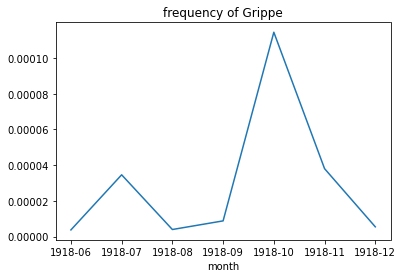

In [27]:
engine.search_and_plot()

# Discussion of the intermediate result 

Is this result meaningful and does it actually reflect something? One way to check that is to compare our plot with the actual data about the intensity of the pandemic. 

In (Taubenberger, J. K., & Morens, D. M. (2006). 1918 Influenza: the Mother of All Pandemics. Emerging Infectious Diseases, 12(1), 15-22. https://doi.org/10.3201/eid1201.050979) it is stated that 'The first pandemic influenza wave appeared in the spring of 1918, followed in rapid succession by much more fatal second and third waves in the fall and winter of 1918–1919, respectively'. They also supplement this statement with a plot from an earlier paper (Jordan  E. (1927). Epidemic influenza: a survey. Chicago: American Medical Association):

<img src="https://wwwnc.cdc.gov/eid/images/05-0979-F1.gif">

Our two waves of mentions of the word 'Grippe' seem to correspond to the mortality figures, which could indicate that the method, albeit very simple, works and that historical events can sometimes be reflected in word frequency counts...

## 2. Exploring the contexts

Let us look at the contexts in which the words appear


### 2.1 KWIC

In [101]:
class ContextViewer:
    
    def __init__(self, corpus_annotated, corpus_metadata):
        self.prepare_index_dataframe_for_search(corpus_annotated, corpus_metadata)
    
    def prepare_index_dataframe_for_search(self, corpus_annotated, corpus_metadata):
        for filename, annotated_text in corpus_annotated.items():
            txtname = filename.replace('.conll', '.txt')
            if txtname in corpus_metadata.index:
                year, month, day = self.get_date_fname(txtname, corpus_metadata)
                annotated_text['month'] = month
                annotated_text['filename'] = filename
        self.full_df = pd.concat(corpus_annotated.values())
        self.full_df = self.full_df.reset_index()
        print(f'Searching in a corpus of {self.full_df.shape[0]} word occurences')
        
    def get_date_fname(self, txtname, corpus_metadata):  
        date = corpus_metadata.loc[txtname, 'Date']
        date = str(date)
        year = date[:4]
        month = f"{date[:4]}-{date[4:6]}"
        day = date
        return year, month, day 
    
    def get_context_words(self, n_words):
        search_lemma = input('Insert a word to search: ')
        if len(search_lemma) == 0:
            search_lemma = 'Grippe'
        indices = self.full_df.query(f'Lemma=="{search_lemma}"').index
        #print(indices)
        left_contexts = []
        this_words = []
        right_contexts = []
        months = []
        for indice in indices:
            left = self.full_df.iloc[indice-10:indice-1, ]["Token"]
            leftс = left[~left.str.contains('\n')]
            right = self.full_df.iloc[indice+1:indice+10, ]["Token"]
            rightс = right[~right.str.contains('\n')]
            left_contexts.append(' '.join(leftс))
            right_contexts.append(' '.join(rightс))
            this_words.append(self.full_df.iloc[indice, ]["Token"])
            months.append(self.full_df.iloc[indice, ]["month"])
        newdf = pd.DataFrame()
        newdf['left_context'] = left_contexts
        newdf['word'] = this_words
        newdf['right_context'] = right_contexts
        newdf['month'] = months
        return newdf
        
    
    def get_context_sents(self, n_sentences):
        search_lemma = input('Insert a word to search: ')
        if len(search_lemma) == 0:
            search_lemma = 'Grippe'
        indices = self.full_df.query(f'Lemma=="{search_lemma}"').index
        #print(indices)
        left_contexts = []
        this_sentences = []
        right_contexts = []
        months = []
        for indice in indices:
            #print(indice)
            current_filename = self.full_df.iloc[indice, ]["filename"]
            current_sentence_id = self.full_df.iloc[indice, ]["Sentence_idx"]
            left_context = self.get_sents(direction=-1, 
                                              current_filename=current_filename, 
                                              current_sentence_id=current_sentence_id, 
                                              n_sentences=n_sentences) 
            left_contexts.append(left_context)
            right_context = self.get_sents(direction=1, 
                                               current_filename=current_filename, 
                                               current_sentence_id=current_sentence_id, 
                                               n_sentences=n_sentences) 
            right_contexts.append(right_context)
            this_sentence = self.get_sents(direction=0, 
                                               current_filename=current_filename,
                                               current_sentence_id=current_sentence_id,
                                               n_sentences=1)
            this_sentences.append(this_sentence)
            #this_words.append(self.full_df.iloc[indice, ]["Token"])
            months.append(self.full_df.iloc[indice, ]["month"])
        newdf = pd.DataFrame()
        newdf['left_sentences'] = left_contexts
        newdf['this_sentence'] = this_sentences
        newdf['right_sentences'] = right_contexts
        newdf['month'] = months
        return newdf #.sort_values(by='month')
    
    def get_sents(self, direction, current_filename, current_sentence_id, n_sentences):
        sentences = []
        for n in range(1,n_sentences+1):
            sentence_id = current_sentence_id + (n * direction)
            this_sentence = self.create_sentence(current_filename, sentence_id)
            sentences.append(this_sentence)
        #print(' '.join(sentences))
        return ' '.join(sentences)
    
    def create_sentence(self, current_filename, sentence_id):
        words = self.full_df.query(f'filename=="{current_filename}" and Sentence_idx=={sentence_id}')['Token']
        sentence = ' '.join(words)
        #print(sentence)
        return sentence
        

In [102]:
kwic = ContextViewer(corpus_annotations, corpus_metadata)

Searching in a corpus of 3008370 word occurences


In [106]:
kwic.get_context_words(n_words=5)

Insert a word to search: Grippe


,left_context,word,right_context,month
0,", 15. Oktober 1918. En LI IR",Grippe,wütel weiter Zunahme der ſcheren Fälle in Berlin,1918-10
1,": Poſen , 14. Oltober . desfälle",Grippe,find in der vergan- „ auf 58 geſtiegen,1918-10
2,einzelne alten werden können . t ſich,Grippe,aus . te fi die Grippewelle N,1918-10
3,"Meldung , Marſchall Io ffr e ſchwer krank",Grippe,darniederliegt . Sein Beſuch in England wurde,1918-10
4,"wurde abgeſagt . Es beſtätigt fie , daß",Grippe,", und gefährliche Epidemien im franzöſiſchen S...",1918-10
5,|| - Zahn- Praxis Klömpen Beize | a,Grippe,DIRE Tr beite wi ; ichel im Gegſcht,1918-12
6,Feldlazarett | im Felde infolge Anſte > ung,Grippe,in „ treuen Pfichterſülung fürs | Vaterland der,1918-09
7,3. verſchied in einem Feld- 8 lazarett infolge,Grippe,"im 32 , Lebensjahre unſer Wi Prokurfft Sert",1918-10
8,von dem am 19. Oltober d. I. infolge,Grippe,"erfolgten Hin- ſcheidens unſeres Prokuriſten ,...",1918-10
9,"Elfe , geb. Freudenthal . Infolge Erkrankung «",Grippe,"mit Lungenentzündung Jam nat kurzem , aber ſch...",1918-10


In [103]:
kwic.get_context_sents(n_sentences=2)

Insert a word to search: 


,left_sentences,this_sentence,right_sentences,month
0,"286. \n\n Dienstag , 15. Oktober 1918. \n rh \...",En LI IR \n\n Zie Grippe wütel weiter \n\n Zun...,Zahl der Grippefälle iſt in den leßten \n heid...,1918-10
1,"8 forte Viederauftreten der E : \n\n Poſen , 1...",desfälle an Grippe find in der vergan- \n „ au...,Vei der \n Ortokrankenkaſſe beirägt die Zahl \...,1918-10
2,"In Hirſc < berg ſind \n en fo bedeutend , daß ...",t ſich die Grippe aus . \n,te fi die Grippewelle \n\n N iegen BEIteTe \n ...,1918-10
3,= Die Dortefs ingen aarfe \n .,"Aus Paris foumt die Meldung , \n Marſchall Io ...",Sein Beſuch in England wurde \n abgeſagt . Es ...,1918-10
4,Sein Beſuch in England wurde \n abgeſagt . Aus...,"Es beſtätigt fie , daß die Grippe , und \n gef...","Eine große Anzahl hoher \n "" ranzöftſcher Offi...",1918-10
5,|| - Zahn- Praxis Klömpen Beize | \n a Een naa...,Die Grippe,DIRE Tr beite wi ; \n,1918-12
6,"Am Dienstag , 27. Auguſt , abends , Verffötb i...",ung en Grippe in „ treuen Pfichterſülung fürs ...,Staſfelarzt ves Staſfelſtabes 247. \n\n Nach k...,1918-09
7,"Am 19. Okiober .d . 45 , \n Wir büten voten , ...",3. verſchied in einem Feld- 8 \n lazarett info...,Mit dem ſo frühen Hinſcheiden dieſes begabten ...,1918-10
8,Mit dem ſo frühen Hinſcheiden dieſes begabten ...,"Die Inhaber der Firma \n Heinrich Stern & Co ,...","Von Anfang des Weltkrieges im Felde , war es \...",1918-10
9,"Pr \n\n und Fran , Elfe , geb. Freudenthal . \...",Infolge Erkrankung « an Grippe mit Lungenentzü...,"geb. Frank , \n int 36. Lebensjahre . \n v peel",1918-10


### 2.2 Collocations